## 환경설정

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
path = 'C:/Users/인공지능사관학교/Desktop/핵심역량프로젝트/'
# path = 'C:/Users/HS/Desktop/전력프로젝트/'
seed = 0

## 데이터

In [127]:
class Datasets:
    
    def __init__(self):
        self.data = pd.read_csv(path+'데이터셋/data_set.csv')
        columns = self.data.columns
        self.scaler_target = StandardScaler()
        self.scaler_target.fit(np.array(self.data['target']).reshape(-1,1))
        self.scaler = StandardScaler()
        self.scaler.fit(self.data)
        self.data = pd.DataFrame(self.scaler.transform(self.data), columns=columns)
        
        
    def load_data(self, split_september=False):
        '''
     
        Returns:
            (train_X, train_y), (test_X, test_y) :  DataFrame, train and target data
            
        '''
        length = len(self.data)
        split_point = int(length * 0.8)
        
        data = self.data[['생산량','기온','풍속','습도','강수량','target']]
        
        if split_september == True:
            split_point = 23329
            train_data = data.iloc[:split_point]
            test_data = data.iloc[split_point:]
        
        else:
            train_data, test_data = train_test_split(data, test_size=0.2, random_state=seed)
        
        train_X = train_data.drop('target', axis=1)
        train_y = train_data['target']
        test_X = test_data.drop('target', axis=1)
        test_y = test_data['target']
        
        return (train_X, train_y), (test_X, test_y)
    
    def load_timeseries_data(self, window_size=10, predict_size=1):
        '''
        Parameter:
        
            window_size : (default=10) set timeseries window size
        
        Return:
        
            (train_X, train_y), (test_X, test_y) : numpy.ndarray, train and target timeseries data  
        '''
        
        data = self.data[['생산량','기온','풍속','습도','강수량', 'day','target']]
        train = []
        target = []
        
        for i in range(len(data) - (window_size+predict_size) + 1):
            temp = data.iloc[i:i + window_size]
            train.append(temp.values)
            target.append(data['target'].iloc[i + window_size : i + window_size + predict_size])
        
        divide_point = len(self.data) - 1344 - window_size
        train_X = np.array(train[:divide_point])
        train_y = np.array(target[:divide_point])
        test_X = np.array(train[divide_point:])
        test_y = np.array(target[divide_point:])
        
        return (train_X, train_y), (test_X , test_y)

### 모델

In [120]:
class Regression_Model:
    def __init__(self):
        self.rfr_model = RandomForestRegressor()
        self.xgb_model = XGBRegressor()
        self.extr_model = ExtraTreesRegressor()
        self.lgbm_model = LGBMRegressor()
        self.model = None
    
    def fit_select_model(self, train_X, train_y):
        '''
        Select model by r2_score in one of RandomForestRegressor, XGBRegressor, ExtraTreeRegressor or LightGBMRegressor.
        
        Parameter:
        
            train_X : train data inputs
            train_y : train data targets
                        
        '''
        
        train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2)
        
        self.rfr_model.fit(train_X, train_y)
        self.xgb_model.fit(train_X, train_y)
        self.extr_model.fit(train_X, train_y)
        self.lgbm_model.fit(train_X, train_y)
        models = [self.rfr_model, self.xgb_model, self.extr_model, self.lgbm_model]
        
        rfr_score = self.rfr_model.score(test_X, test_y)
        xgb_score = self.xgb_model.score(test_X, test_y)
        extr_score = self.extr_model.score(test_X, test_y)
        lgbm_score = self.lgbm_model.score(test_X, test_y)
        
        scores = np.array([rfr_score, xgb_score, extr_score, lgbm_score])
        
        choice = np.argmax(scores)

        self.model = models[choice]
            
            
    def predict(self, inputs):
        '''
        Parameter:
        
            inputs : test data inputs
                    
        Return:
            
            data predicted by seleted model
        '''
        
        return self.model.predict(inputs)
    
    def score(self, test_X, test_y, score_type='r2_score'):
        '''
        Parameter:
        
            test_X : test data inputs
            test_y : test data targets
            score_type : (default='r2_score') score type {'r2_score', 'MAE', 'MSE', 'MSLE'}
        
        Return:
        
            selected score in {'r2_score', 'MAE', 'MSE', 'MSLE'}
        '''
        
        
        pred_y = self.model.predict(test_X)
        if score_type == 'MAE':
            score = mean_absolute_error(test_y, pred_y)
        elif score_type == 'MSE':
            score = mean_squared_error(test_y, pred_y)
        elif score_type == 'MSLE':
            score = mean_squared_log_error(test_y, pred_y)
        else:
            score = r2_score(test_y, pred_y)
        
        return score
        

class RNN_Model:
    def __init__(self, input_data, target_data, optimizer='Adam', loss='MSE'):
        '''
        Parameter:
        
            input_data : train data inputs or test data inputs, it is for making input layer.
            optimizer : (default='Adam') keras optimizers
            loss : (default='MSE') keras losses for regressor
        
        '''
        
        input_shape = input_data[0].shape
        target_shape = target_data[0].shape[0]
        
        inputs = tf.keras.layers.Input(shape=input_shape)
        lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs)
        lstm2 = tf.keras.layers.LSTM(64)(lstm)
        
        d1 = tf.keras.layers.Dense(64, activation='relu')(lstm2)
        d2 = tf.keras.layers.Dense(32, activation='relu')(d1)
        
        outputs = tf.keras.layers.Dense(target_shape)(d2)
        
        self.model = tf.keras.Model(inputs, outputs)
        
        self.model.compile(optimizer=optimizer, loss=loss)
        
    
    def load_model(self, model_path):
        '''
        Parameter:
        
            model_path : directory for saved model(.h5)
        
        '''
        
        self.model = tf.keras.models.load_model(model_path)
        
        
    def fit(self, train_X, train_y, val_data = None,
           batch_size=32, epochs=10, patience=20):
        '''
        Parameter:
        
            train_X : train data inputs
            train_y : train data targets
            
            val_data : (default=None) if val_data is None, data is splited 0.2 size.
                        (val_X, val_y) must be tuple.
            batch_size : (dafault=32) integer
            epochs : (dafault=10) integer
            patience : (default=20) integer, it's for EarlyStopping callbacks patience.
        
        '''
        
        
        es = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
        
        
        if val_data is None:
            train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2)
            val_data = (val_X, val_y)
            
            
        self.model.fit(train_X, train_y,
                      batch_size=batch_size, epochs=epochs,
                      validation_data=val_data, callbacks=[es])

        
    def score(self, test_X, test_y, score_type="r2_score"):
        '''
        Parameter:
        
            test_X : test data inputs
            test_y : test data targets
            score_type : (default='r2_score') score type {'r2_score', 'MAE', 'MSE', 'MSLE'}
        
        Return:
        
            selected score in {'r2_score', 'MAE', 'MSE', 'MSLE'}
        '''
        
        pred_y = self.model.predict(test_X)
        
        if score_type == 'MAE':
            score = mean_absolute_error(test_y, pred_y)
        elif score_type == 'MSE':
            score = mean_squared_error(test_y, pred_y)
        elif score_type == 'MSLE':
            score = mean_squared_log_error(test_y, pred_y)
        else:
            score = r2_score(test_y, pred_y)
            
        return score
    
    def predict(self, inputs):
        '''
        Parameter:
        
            inputs : test data inputs
                    
        Return:
            
            data predicted by fitted model
        '''
        
        return self.model.predict(inputs)

### 그래프

In [121]:
def show_plot(pred_y, real_y):
    '''
    Make plot with matplotlib.pyplot, especially steptember's data.
    
    Parameter:
        pred_y : model predict value
        real_y : real value(test target)
        
    '''
    
    plt.figure(figsize=(25,10))
    
    x_lin = np.arange(len(pred_y))
    
    plt.plot(x_lin, pred_y, color='orange', label='predict_value', alpha=0.9,  linewidth=2.2)
    plt.plot(x_lin, real_y, color='blue', label='real_value', alpha=0.3, linewidth=2.2)
    
    plt.xticks([i for i in range(0, len(pred_y)+24, 4*24)],
               labels=['9/%d' %(i) for i in range(1, 16)],
              color = 'black', fontsize=20)
    plt.yticks(color = 'black', fontsize=20)
    plt.grid()
    
    plt.legend(fontsize=24, loc=0)
    
    plt.show()

### 모델 준비 및 훈련

In [128]:
data = Datasets()

In [129]:
(train_X, train_y), (test_X, test_y) = data.load_data(split_september=False)
(train_X_timeseries, train_y_timeseries), (test_X_timeseries, test_y_timeseries) =\
                                                                data.load_timeseries_data(672,96)

In [124]:
model_ML= Regression_Model()

model_ML.fit_select_model(train_X, train_y)
score_ML = model_ML.score(test_X, test_y)

pred_y_ML = model_ML.predict(test_X)



ML model score : 0.8217709719109171


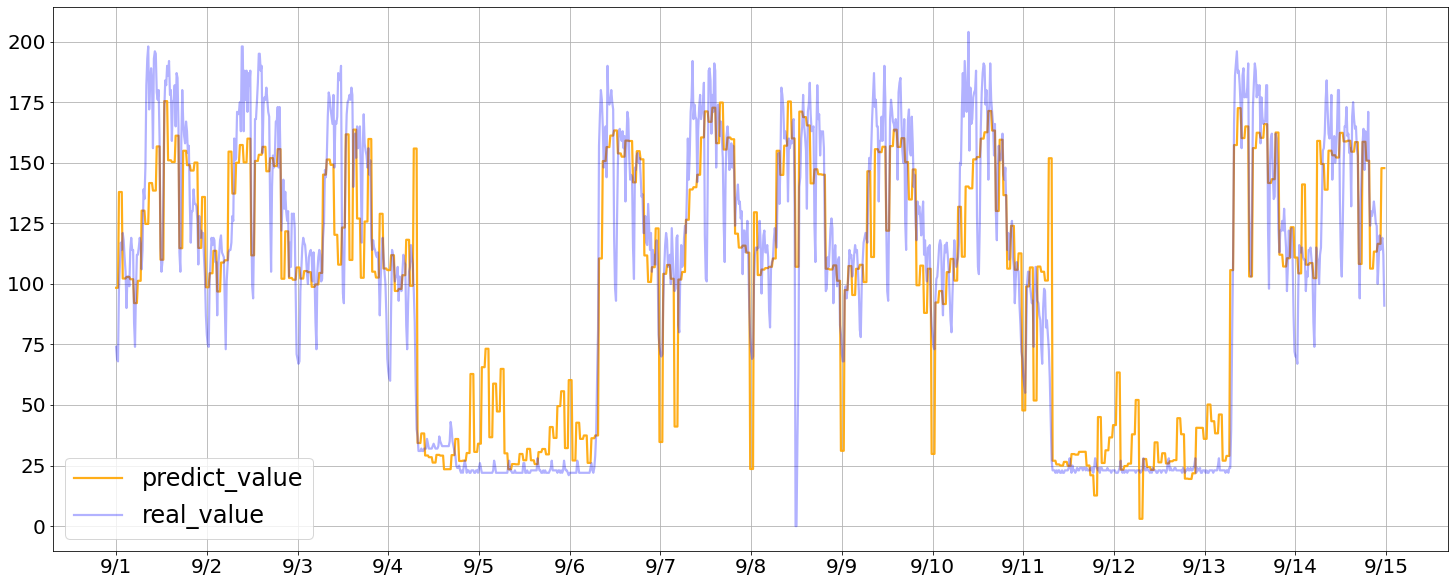

In [82]:
print('ML model score :', score_ML)
target_scaler = data.scaler_target

inverse_pred = target_scaler.inverse_transform(pred_y_ML.reshape(1,-1)).reshape(-1)
inverse_real = target_scaler.inverse_transform(np.array(test_y).reshape(1,-1)).reshape(-1)

show_plot(inverse_pred, inverse_real)

ML model score : 0.9289070467640054


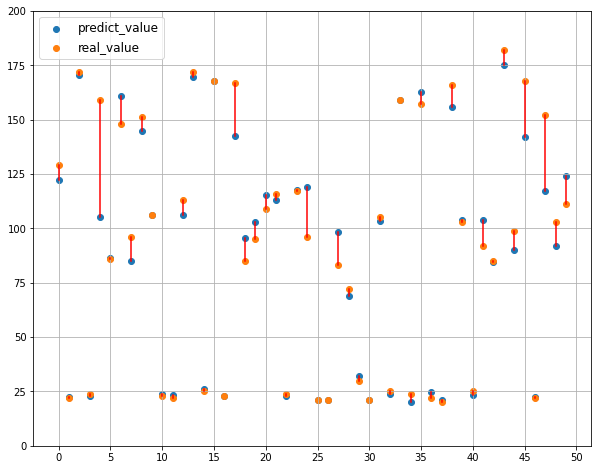

In [97]:
print('ML model score :', score_ML)
target_scaler = data.scaler_target

inverse_pred = target_scaler.inverse_transform(pred_y_ML.reshape(1,-1)).reshape(-1)
inverse_real = target_scaler.inverse_transform(np.array(test_y).reshape(1,-1)).reshape(-1)

plt.figure(figsize=(10,8))
plt.scatter(np.arange(50), inverse_pred[:50], label='predict_value')
plt.scatter(np.arange(50), inverse_real[:50], label='real_value')
plt.legend(fontsize=12)
plt.xticks([i for i in range(0,51,5)])

plt.ylim(0,200)
for i in range(0,50):
    max_p, min_p = np.max([inverse_pred[i], inverse_real[i]]), np.min([inverse_pred[i], inverse_real[i]])
    plt.axvline(i, max_p/200, min_p/200, color='red' )
plt.grid()

plt.show()
# show_plot(inverse_pred, inverse_real)

In [130]:
model_DL = RNN_Model(input_data=train_X_timeseries, target_data=train_y_timeseries)

# with tf.device("/device:GPU:0"):
#     model_DL.fit(train_X_timeseries, train_y_timeseries, epochs=1, patience=10)

model_DL.load_model('lstm_oneday_4.h5')
score_DL = model_DL.score(test_X_timeseries, test_y_timeseries)

pred_y_DL = model_DL.predict(test_X_timeseries)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
40/40 [==============================] - 1s 36ms/step


1/1 [==============================] - 0s 27ms/step


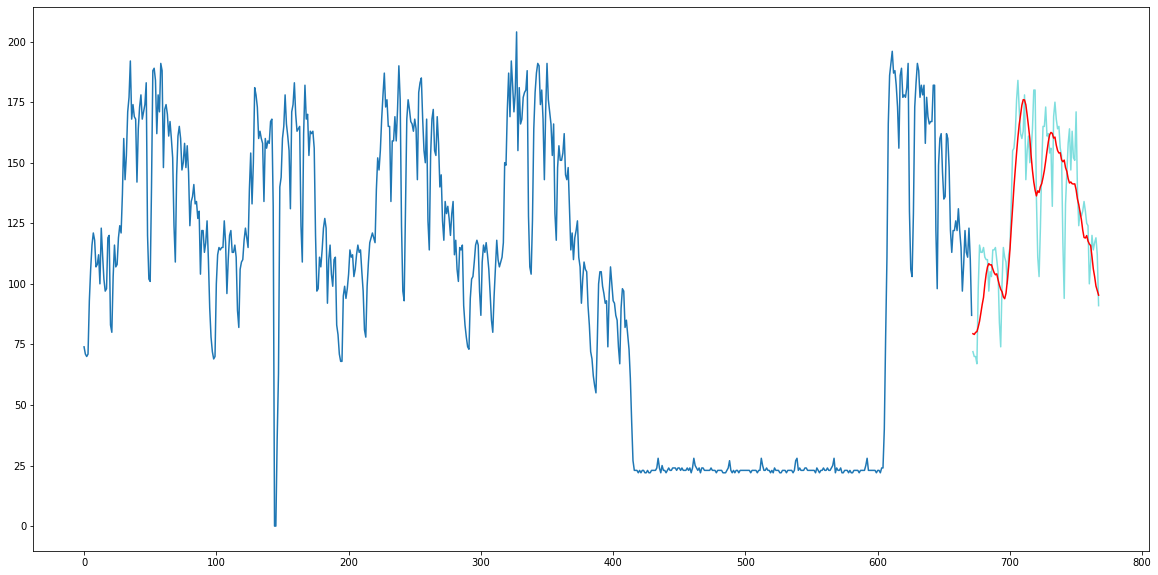

In [131]:
plt.figure(figsize=(20,10))
point = 96*13
plt.plot(np.arange(672), test_X_timeseries[point,:,-1])
plt.plot(np.arange(672, 672+96), test_y_timeseries[point], color='c', alpha=0.5, label='real_value')
plt.plot(np.arange(672, 672+96), model_DL.predict(test_X_timeseries[point:point+1]).reshape(96,),
         color='red', label='predict_value')

plt.show()

In [132]:
real_value = [test_y_timeseries[i] for i in range(0,1250, 96)]
pred_value = [model_DL.predict(test_X_timeseries[i:i+1]).reshape(96,) for i in range(0,1250,96)]

1/1 [==============================] - 0s 37ms/step


In [133]:
rr = []
pr = []
for i in range(len(real_value)):
    rr.extend(real_value[i])
    pr.extend(pred_value[i])

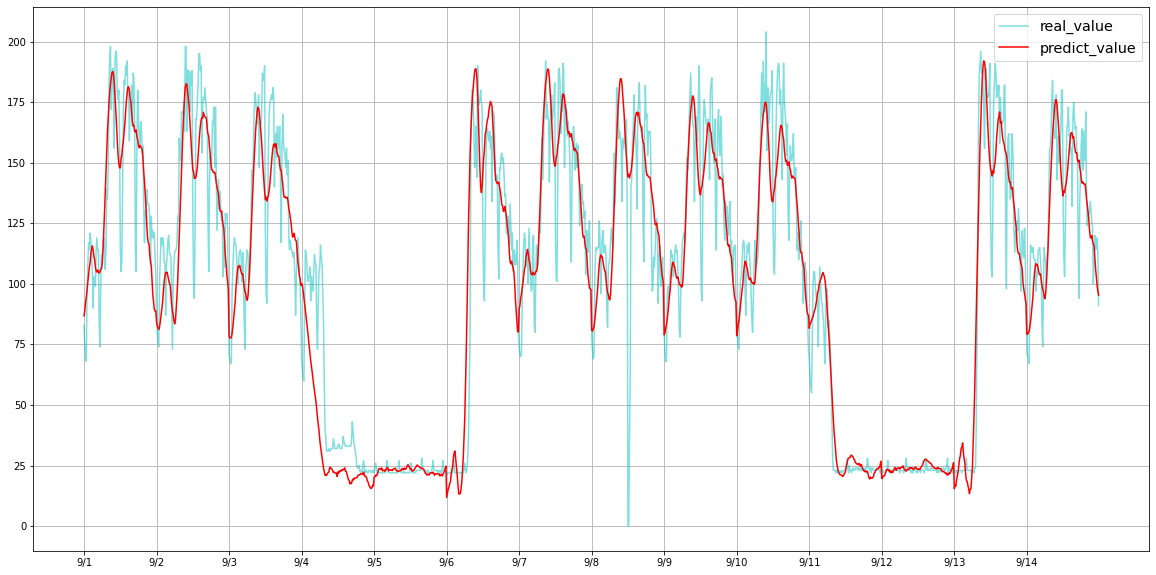

In [134]:
plt.figure(figsize=(20,10))
# point = 96*13
plt.plot(np.arange(1344), rr, color='c', alpha=0.5, label='real_value')
plt.plot(np.arange(1344), pr,
         color='red', label='predict_value')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(0,1344, 96), ['9/%d' % i for i in range(1,15)])
plt.show()

## 평가지표

In [104]:
def gap_peak_time(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError('error msg')
        
    result = []
    
    for i in range(len(y_true)):
        gap = abs(np.argmax(y_true[i]) - np.argmax(y_pred[i]))
        result.append(gap)
    
    return np.mean(result)

In [105]:
def gap_peak_value(y_true, y_pred, max_point=False):
    if len(y_true) != len(y_pred):
        raise ValueError('error msg')
        
    result = []
    
    if max_point:
        for i in range(len(y_true)):
            max_idx = np.argmax(y_true[i])
            gap = abs(y_true[i][max_idx] - y_pred[i][max_idx])
    else:
        for i in range(len(y_true)):
            gap = abs(np.max(y_true[i]) - np.max(y_pred[i]))
            result.append(gap)
    
    return np.mean(result)

In [98]:
model_lst = ['lstm_one_days.h5', 'lstm_oneday_2.h5', 'lstm_oneday_3.h5', 'lstm_oneday_4.h5', 'final_model.h5']

In [106]:
time_score = []
value_score = []
for model_name in model_lst:
    temp_model = tf.keras.models.load_model(model_name)
    pred_y_t = temp_model.predict(test_X_timeseries)
    time_score.append(gap_peak_time([test_y_timeseries[i] for i in range(0,1248,96)], [pred_y_t[i] for i in range(0,1248,96)]))
    value_score.append(gap_peak_value([test_y_timeseries[i] for i in range(0,1248,96)], [pred_y_t[i] for i in range(0,1248,96)]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
40/40 [==============================] - 1s 17ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report

In [118]:
pd.DataFrame([time_score, value_score], index=['time_gap', 'value_gap'], columns=['model1','model2','model3','model4','model5', 'model6']).T

,time_gap,value_gap
model1,16.615385,18.925923
model2,19.923077,24.487587
model3,17.538462,22.070190
model4,10.000000,8.914862
model5,20.145752,23.175115
model6,12.769231,10.568480
